##### Copyright 2018 The TensorFlow Authors.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from tensorflow import keras
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train your model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 392s 0us/step


In [4]:
# annotation_file = '/content/annotations/captions_train2014.json'
# PATH = '/content/train2014/'

## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train your model. Choosing to use more data would result in improved captioning quality.

In [5]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [6]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [7]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [8]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> Two elephants stand side by side in a grassy open area with a tree in the background. <end>


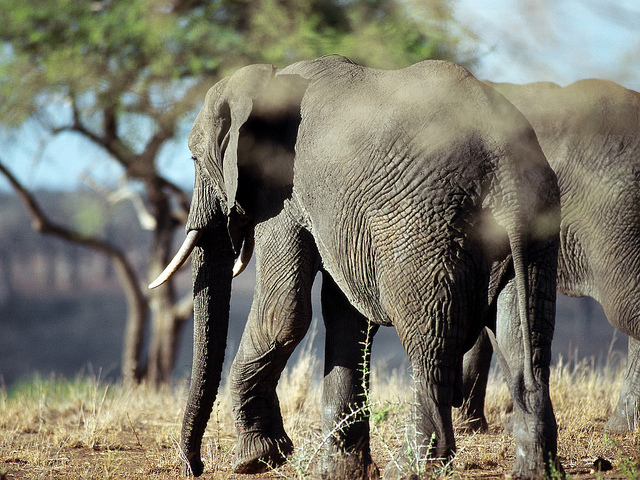

In [9]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [10]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you save the dictionary to disk.


In [11]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 2s 0us/step


## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. Install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [12]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top 5,000 words (to save memory).
* Tokenize all captions by mapping each word to it's index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [13]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [14]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [15]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## Split the data into training and testing

In [16]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 60-20-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

val_slice_index = int(len(img_keys)*0.6)
test_slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys, img_name_test_keys = img_keys[:val_slice_index], img_keys[val_slice_index: test_slice_index], img_keys[test_slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

img_name_test = []
cap_test = []
for imgv in img_name_test_keys:
  capte_len = len(img_to_cap_vector[imgv])
  img_name_test.extend([imgv] * capte_len)
  cap_test.extend(img_to_cap_vector[imgv])

In [17]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val), len(img_name_test), len(cap_test)

(18008, 18008, 6002, 6002, 6002, 6002)

## Create a tf.data dataset for training


Your images and captions are ready! Next, let's create a `tf.data` dataset to use for training your model.

In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

def map_func(img_name, cap):
   img_tensor = np.load(img_name.decode('utf-8')+'.npy')
   return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int64]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Create dataset for validation

In [19]:
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# # Shuffle and batch
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE) # Batch_size * (img_name_val, cap_val)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Create dataset for testing

In [20]:
test_dataset = tf.data.Dataset.from_tensor_slices((img_name_test, cap_test))

# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# # Shuffle and batch
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE) # Batch_size * (img_name_test, cap_test)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Positional Encoding

In [21]:
def get_angles(pos, i, d_model):
   angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
   return pos * angle_rates

def positional_encoding_1d(position, d_model):
   angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)

   angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
   angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
   pos_encoding = angle_rads[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32) #dtype=tf.float32)

def positional_encoding_2d(row,col,d_model):
   assert d_model % 2 == 0
   row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
   col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

   angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
   angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

   angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
   angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
   angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
   angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
   pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32) #dtype=tf.float32)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [22]:
def create_padding_mask(seq):
   seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
   return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
   mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
   return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
   matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
   dk = tf.cast(tf.shape(k)[-1], tf.float32)
   scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

   if mask is not None:
      scaled_attention_logits += (mask * -1e9) 

   attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
   output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

   return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads):
      super(MultiHeadAttention, self).__init__()
      self.num_heads = num_heads
      self.d_model = d_model
      assert d_model % self.num_heads == 0
      self.depth = d_model // self.num_heads
      self.wq = tf.keras.layers.Dense(d_model)
      self.wk = tf.keras.layers.Dense(d_model)
      self.wv = tf.keras.layers.Dense(d_model)
      self.dense = tf.keras.layers.Dense(d_model)

   def split_heads(self, x, batch_size):
      x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
      return tf.transpose(x, perm=[0, 2, 1, 3])

   def call(self, v, k, q, mask=None):
      batch_size = tf.shape(q)[0]
      q = self.wq(q)  # (batch_size, seq_len, d_model)
      k = self.wk(k)  # (batch_size, seq_len, d_model)
      v = self.wv(v)  # (batch_size, seq_len, d_model)

      q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
      k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
      v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

      scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
      scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

      concat_attention = tf.reshape(scaled_attention,
                                 (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

      output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
      return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
   return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                tf.keras.layers.Dense(d_model)])  # (batch_size, seq_len, d_model)])

Encoder-Decoder Layer

In [23]:
class EncoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(EncoderLayer, self).__init__()
      self.mha = MultiHeadAttention(d_model, num_heads)
      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)


   def call(self, x, training, mask=None):
      attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
      attn_output = self.dropout1(attn_output, training=training)
      out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

      ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
      ffn_output = self.dropout2(ffn_output, training=training)
      out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
      return out2

class DecoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(DecoderLayer, self).__init__()
      self.mha1 = MultiHeadAttention(d_model, num_heads)
      self.mha2 = MultiHeadAttention(d_model, num_heads)

      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)
      self.dropout3 = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
      attn1 = self.dropout1(attn1, training=training)
      out1 = self.layernorm1(attn1 + x)

      attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
      attn2 = self.dropout2(attn2, training=training)
      out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

      ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
      ffn_output = self.dropout3(ffn_output, training=training)
      out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

      return out3, attn_weights_block1, attn_weights_block2

class Encoder(tf.keras.layers.Layer):
   def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size,rate=0.1):
      super(Encoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
      self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

      self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, training, mask=None):
      seq_len = tf.shape(x)[1]
      x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x = self.enc_layers[i](x, training, mask)

      return x  # (batch_size, input_seq_len, d_model)

class Decoder(tf.keras.layers.Layer):
   def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding,   rate=0.1):
      super(Decoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
      self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

      self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      seq_len = tf.shape(x)[1]
      attention_weights = {}

      x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)
         
         attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
         attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

      return x, attention_weights


Transformer

In [24]:
class Transformer(tf.keras.Model):
   def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
              target_vocab_size,max_pos_encoding, rate=0.1):
      super(Transformer, self).__init__()
      self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)
      self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                          target_vocab_size,max_pos_encoding, rate)
      self.final_layer = tf.keras.layers.Dense(target_vocab_size)

   def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
      enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model      )
      dec_output, attention_weights = self.decoder(
      tar, enc_output, training, look_ahead_mask, dec_padding_mask)
      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
      return final_output, attention_weights

Model Hyperparameters

In [25]:
num_layer = 1
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = vocabulary_size + 1
dropout_rate = 0.1 

In [26]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
   def __init__(self, d_model, warmup_steps=4000):
      super(CustomSchedule, self).__init__()
      self.d_model = d_model
      self.d_model = tf.cast(self.d_model, tf.float32)
      self.warmup_steps = warmup_steps

   def __call__(self, step):
      arg1 = tf.math.rsqrt(step)
      arg2 = step * (self.warmup_steps ** -1.5)
      return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [27]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size, max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [28]:
# checkpoint_path = "./checkpoints/train"
checkpoint_path = '/content/drive/MyDrive/My Senior Project Spring 2022/checkpoint/Transformer'
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [29]:
print(start_epoch)

20


In [30]:
f0 = open("/content/drive/MyDrive/My Senior Project Spring 2022/checkpoint/Transformer/train_losses.txt", "w")
f1 = open("/content/drive/MyDrive/My Senior Project Spring 2022/checkpoint/Transformer/train_accuracies.txt", "w")
f2 = open("/content/drive/MyDrive/My Senior Project Spring 2022/checkpoint/Transformer/val_losses.txt", "w")
f3 = open("/content/drive/MyDrive/My Senior Project Spring 2022/checkpoint/Transformer/val_accuracies.txt", "w")

Model Training

In [31]:
def create_masks_decoder(tar):
   look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
   dec_target_padding_mask = create_padding_mask(tar)
   combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
   return combined_mask

def train_step(img_tensor, tar, is_training=True):
   tar_inp = tar[:, :-1]
   tar_real = tar[:, 1:]
   dec_mask = create_masks_decoder(tar_inp)

   if is_training:
     with tf.GradientTape() as tape:
         predictions, _ = transformer(img_tensor, tar_inp, True, dec_mask)
         loss = loss_function(tar_real, predictions)

     gradients = tape.gradient(loss, transformer.trainable_variables)   
     optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
     train_loss(loss)
     train_accuracy(tar_real, predictions)
   else:
     predictions, _ = transformer(img_tensor, tar_inp, False, dec_mask)
     loss = loss_function(tar_real, predictions)

     val_loss(loss)
     val_accuracy(tar_real, predictions)
   

train_losses = []
train_accuracies = []

val_losses = []
val_accuracies = []

for epoch in range(start_epoch, 21):
   start = time.time()
   train_loss.reset_states()
   train_accuracy.reset_states()
   for (batch, (img_tensor, tar)) in enumerate(dataset):
      train_step(img_tensor, tar)
      if batch % 50 == 0:
         print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
         epoch + 1, batch, train_loss.result(), train_accuracy.result()))

   train_losses.append(train_loss.result())
   train_accuracies.append(train_accuracy.result())

   f0.write(str(train_loss.result().numpy()))
   f1.write(str(train_accuracy.result().numpy()))


   # validation
   val_loss.reset_states()
   val_accuracy.reset_states()
   for (batch, (img_tensor, tar)) in enumerate(val_dataset):
     train_step(img_tensor, tar, False)
     if batch % 50 == 0:
         print ('Epoch {} Batch {} Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(
         epoch + 1, batch, val_loss.result(), val_accuracy.result()))

   val_losses.append(val_loss.result())
   val_accuracies.append(val_accuracy.result())

   f2.write(str(val_loss.result().numpy()))
   f3.write(str(val_accuracy.result().numpy()))


   if epoch % 10 == 0:
      ckpt_manager.save(checkpoint_number=epoch)     

   print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
   
   print ('Epoch {} Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                               val_loss.result(),
                                               val_accuracy.result()))
   
   print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

f0.close()
f1.close()
f2.close()
f3.close()

Epoch 21 Batch 0 Loss 6.5294 Accuracy 0.0494
Epoch 21 Batch 50 Loss 5.0815 Accuracy 0.0620
Epoch 21 Batch 100 Loss 4.7160 Accuracy 0.0688
Epoch 21 Batch 150 Loss 4.4629 Accuracy 0.0732
Epoch 21 Batch 200 Loss 4.2728 Accuracy 0.0767
Epoch 21 Batch 250 Loss 4.1336 Accuracy 0.0791
Epoch 21 Batch 0 Validation Loss 3.1671 Validation Accuracy 0.0973
Epoch 21 Batch 50 Validation Loss 3.4555 Validation Accuracy 0.0914
Epoch 21 Loss 4.0597 Accuracy 0.0803
Epoch 21 Validation Loss 3.4441 Validation Accuracy 0.0911
Time taken for 1 epoch: 52.09605956077576 secs



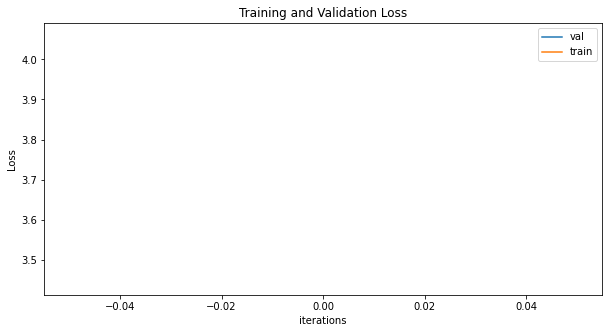

In [32]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

1


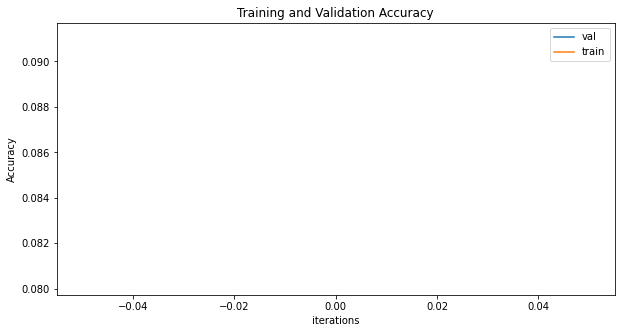

In [33]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracies,label="val")
plt.plot(train_accuracies,label="train")
print(len(train_accuracies))
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Evaluate

In [34]:
from nltk.translate.bleu_score import sentence_bleu

In [35]:
IMAGE_SIZE = (299,299)

In [36]:
def get_cnn_model():
    image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
    # We freeze our feature extractor
    image_model.trainable = False
    base_model_out = image_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(image_model.input, base_model_out)
    return cnn_model

In [37]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

In [38]:
cnn_model = get_cnn_model()

In [39]:
def evaluate(image):
   temp_input = tf.expand_dims(decode_and_resize(image), 0)
   img_tensor_val = cnn_model(temp_input)
  #  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   start_token = word_to_index(tf.constant('<start>'))
   end_token = word_to_index(tf.constant('<end>'))
   decoder_input = [start_token]
   output = tf.expand_dims(decoder_input, 0) #tokens
   result = [] #word list

   for i in range(100):
      dec_mask = create_masks_decoder(output)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      # print(predictions.shape)
      # print(output.shape)


      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int64)
      if predicted_id == end_token:
         return result,tf.squeeze(output, axis=0), attention_weights
      result.append(tf.compat.as_text(index_to_word(int(predicted_id.numpy())).numpy()))
      output = tf.concat([output, predicted_id], axis=-1)

   return result,tf.squeeze(output, axis=0), attention_weights

In [45]:
def test_single_img(id):
  image = img_name_test[id]

  caption = cap_test[id]

  bleu_scores = []
  # for caption in captions:
  real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in caption if i not in [0]])
  caption, result, _ = evaluate(image)

  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]

  for i in caption:
    if i=="<unk>":
        caption.remove(i)

  for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

  result_join = ' '.join(caption)
  result_final = result_join.rsplit(' ', 1)[0]
  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = caption

  # score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
  # print(f"BLEU-1 score: {score*100}")
  # score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
  # print(f"BLEU-2 score: {score*100}")
  # score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
  # print(f"BLEU-3 score: {score*100}")
  score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
  bleu_scores.append(score)
  print(f"BLEU-4 score: {score*100}")

  print ('Real Caption:', real_caption)
  print ('Predicted Caption:', ' '.join(caption))
  temp_image = np.array(Image.open(image))
  plt.imshow(temp_image)

  return np.mean(bleu_scores)

BLEU-4 score: 25.132936350227652
Real Caption: a group of people skiing on white slope next to trees.
Predicted Caption: a group of people are standing on a ski slope.


0.2513293635022765

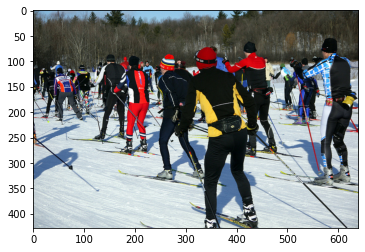

In [47]:
test_single_img(1)

In [ ]:
import random

img_test_idx = random.sample(range(len(img_name_test)), 100)

In [ ]:
len(img_name_test)

6002

In [ ]:
bleu_scores = []
for i in range(len(img_name_test)):
  bleu_score = test_single_img(i)
  bleu_scores.append(bleu_score)

np.mean(bleu_scores)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.47902648498647227

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.